# **Project Description: Natural Disaster Tweets Classification**
 
Each sample in the train set has the following information:

- The text of a tweet
- A keyword from that tweet (although this may be blank!)
- The location the tweet was sent from (may also be blank)

# **Dataset**:

- The project is from a dataset from Kaggle.
- Link to the Kaggle project site: https://www.kaggle.com/competitions/nlp-getting-started/data
- The dataset has to be downloaded from the above Kagglewebsite.

# **Objective**:

- To predict whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

# **Outcomes**:
- Text based Exploratory Data Analysis
- Basic text pre-processing.
- What to do after text pre-processing:
    - Bag of words
    - Tf-idf
- Build a classification model (Random Forest).
- Plot the  important features after training each model.
- Integrate GloVe model
- Build an SGD Classifier model using GloVe vectors.

### Import required packages

In [1]:
# install and import necessary libraries.

!pip install contractions         # we use contractions library to fix contractions e.g. don't becomes do not

import re, string, unicodedata                          # Import Regex, string and unicodedata.
import contractions                                     # Import contractions library.
from bs4 import BeautifulSoup                           # Import BeautifulSoup.

import numpy as np                                      # Import numpy.
import pandas as pd                                     # Import pandas.
import nltk                                             # Import Natural Language Tool-Kit.

nltk.download('stopwords')                              # Download Stopwords.
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.
import matplotlib.pyplot as plt                         
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 110 kB 13.7 MB/s 
     |████████████████████████████████| 287 kB 23.2 MB/s 


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [2]:
from google.colab import drive
drive.mount("/content/drive")   # mount google drive to load data from drive

Mounted at /content/drive


In [93]:
# function to load the data. Input is the path to the data
def get_data(path):
  df = pd.read_csv(path)
  return df

In [95]:
# Loading train and test data into pandas dataframe
train_data = get_data("/content/drive/MyDrive/nlp-getting-started/train.csv")


In [96]:
train_data.shape                                               # print shape of train data.

(7613, 5)

In [6]:
train_data.head()                                              # Print first 5 rows of train data.

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
train_data.location.nunique()                              # number of unique locations

3341

In [8]:
train_data.isnull().sum(axis=0)                                # Check for NULL values.

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

- The keyword column has 61 missing rows.
- The location column has 2533 missing rows.
- The text and target columns we would be using for this project have no missing values.

**Function to create labeled barplots**

In [9]:

 # function to create labeled barplots

def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

####**Percentage of tweets for each target label**

---



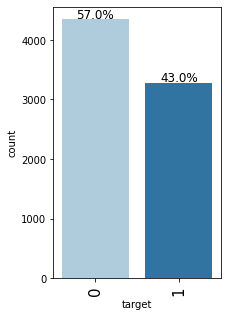

In [10]:
labeled_barplot(train_data, "target", perc=True)

 - **We can see the percentage of tweets classified as no disaster has the highest number of tweets i.e. 57%, followed by no disaster (43%)**.

### **Word Cloud for Tweets labelled as disaster**

In [11]:
from wordcloud import WordCloud,STOPWORDS


In [12]:
disaster_tweets = train_data[train_data['target'] == 1]              # filtering data to data labelled as disaster
words = ' '.join(disaster_tweets['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                                and not word.startswith("#")
                            ])

In [13]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

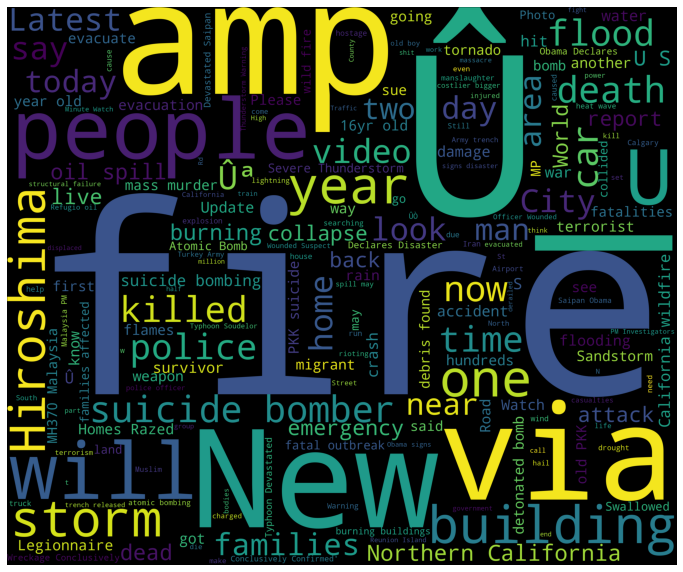

In [14]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

- **Tweets classified as disaster frequently involved few words like fire, death, storm, and burning buildings, car accident, etc.**

### **Wordcloud for Tweets classified as not disaster**

In [15]:
no_disaster_tweets = train_data[train_data['target'] == 0]  # filtering data to data labelled as no disaster
words = ' '.join(no_disaster_tweets['text'])                # obtaining the text column
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                                and not word.startswith("#")
                            ])

In [16]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

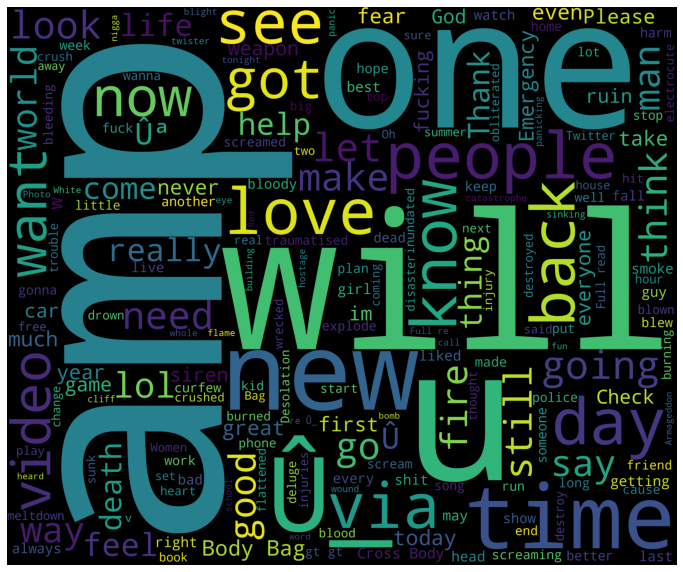

In [17]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [18]:
train_data = train_data[['text', 'target']]      # selecting only the text and target columns in train


In [19]:
pd.set_option('display.max_colwidth', None) # Display full dataframe information (Non-turncated Text column.)

train_data.head()                                 # Check first 5 rows of data

,text,target
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,"13,000 people receive #wildfires evacuation orders in California",1
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


#**Data Pre-processing:**

- Remove html tags.
- Replace contractions in string. (e.g. replace I'm --> I am) and so on.
- Remove numbers.
- Tokenization
- To remove Stopwords.
- Lemmatized data
- I have used NLTK library to tokenize words , remove stopwords and lemmatize the remaining words.

In [20]:
# function to remove html tags
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

train_data['text'] = train_data['text'].apply(lambda x: strip_html(x))


In [21]:
# function to fix contractions
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

train_data['text'] = train_data['text'].apply(lambda x: replace_contractions(x))


In [22]:
# function to remove digits from text
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

train_data['text'] = train_data['text'].apply(lambda x: remove_numbers(x))


In [23]:
train_data['text'] = train_data.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) # Tokenizing train data


In [24]:
train_data.head()                                             # Look at how tokenized data looks.

,text,target
0,"[Our, Deeds, are, the, Reason, of, this, #, earthquake, May, ALLAH, Forgive, us, all]",1
1,"[Forest, fire, near, La, Ronge, Sask, ., Canada]",1
2,"[All, residents, asked, to, 'shelter, in, place, ', are, being, notified, by, officers, ., No, other, evacuation, or, shelter, in, place, orders, are, expected]",1
3,"[,, people, receive, #, wildfires, evacuation, orders, in, California]",1
4,"[Just, got, sent, this, photo, from, Ruby, #, Alaska, as, smoke, from, #, wildfires, pours, into, a, school]",1


In [25]:
stopwords = stopwords.words('english')   # obtaining english stopwords (commonly used words)                           

In [26]:
lemmatizer = WordNetLemmatizer()   # initializing WordNetLemmatizer for lemmatization

# function to remove special characters
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

# function to convert text to lowercase
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

# function to remove punctuation
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

# function to remove stopwords
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

# function to lemmatize text data
def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

# putting all the above functions together
def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

train_data['text'] = train_data.apply(lambda row: normalize(row['text']), axis=1)


In [27]:
train_data.head()      # sanity check

,text,target
0,deeds reason earthquake may allah forgive us,1
1,forest fire near la ronge sask canada,1
2,residents ask shelter place notify officer evacuation shelter place order expect,1
3,people receive wildfires evacuation order california,1
4,get send photo ruby alaska smoke wildfires pour school,1


###**Building bag of words model and Random forest**
- My choice of random forest here is due to the robustness of tree-based models. The data obtained from TF-IDF vectorizer are sparse matrix (full of zeros), hence conventional linear model may not be able to capture the semantic information in the data.
- Also, we use cross-validation (cross-val-score) to get an idea of the generalization performance of the model.

In [75]:
# Vectorization (Convert text data to numbers).
from sklearn.feature_extraction.text import CountVectorizer

Count_vec = CountVectorizer(max_features=500)                # Keep only 500 features as number of features will increase the processing time.
data_features = Count_vec.fit_transform(train_data['text'])

data_features = data_features.toarray()                        # Convert the data features to array.

In [76]:
data_features.shape

(7613, 500)

In [77]:
X = data_features

y = train_data.target

In [78]:
# Split data into training and testing set.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [79]:
# Using Random Forest to build model for the classification of the tweets.
# Also calculating the cross validation score.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

forest = RandomForestClassifier(n_jobs=-1, random_state = 0)

forest = forest.fit(X_train, y_train)   # train the model

print(forest)

print(np.mean(cross_val_score(forest, X_train, y_train, cv=3)))

RandomForestClassifier(n_jobs=-1, random_state=0)
0.7677691580117414


- Based on the results above, our Random Forest Classifier would correctly classify a tweet in a new dataset as either real disaster or not 77% of the time using Bag of Words model.

In [80]:
# Predict the result for test data using the model built above.

result = forest.predict(X_test)

### Plot of Evaluation

[[334  92]
 [109 227]]


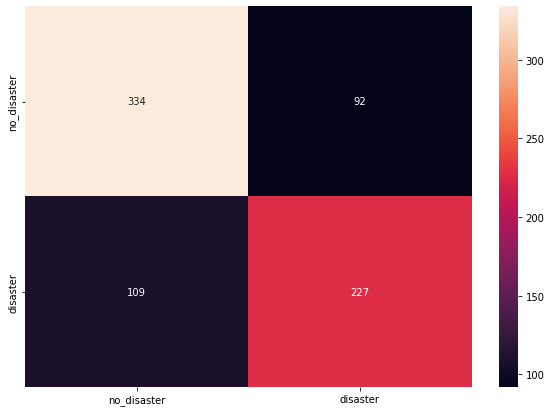

In [82]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among  the classes.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, result)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ['no_disaster', 'disaster']],
                  columns = [i for i in ['no_disaster', 'disaster']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g');

- Our Random Forest model wrongly classifies 109 tweets labeled as disaster as no disaster.

**Wordcloud of top 40 important features from bag_of_words+Randomforest based model**

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


http,fire,kill,hiroshima,california,bomb,get,https,train,storm,suicide,like,flood,disaster,report,build,attack,go,earthquake,wildfire,new,mh,news,police,accident,japan,derailment,typhoon,crash,shoot,full,refugees,murder,see,via,want,deaths,spill,come,evacuate,
 
 


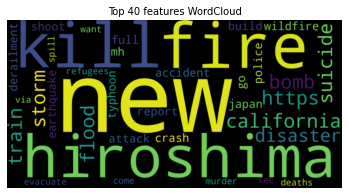

In [83]:
all_features = Count_vec.get_feature_names()              #Instantiate the feature from the vectorizer
top_features=''                                            # Addition of top 40 feature into top_feature after training the model
feat= forest.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features+=all_features[i]
    top_features+=','
    
print(top_features)  

print(" ") 
print(" ")     

from wordcloud import WordCloud
wordcloud = WordCloud(colormap='viridis',width=2000, 
                          height=1000).generate(top_features)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(14, 11), frameon='equal')
plt.title('Top 40 features WordCloud', fontsize=10)
plt.axis("off")
plt.show()

**Term Frequency(TF) - Inverse Document Frequency(IDF)**

In [84]:
# Using TfidfVectorizer to convert text data to numbers.

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(max_features=500)     # selecting only 500 features
data_features = tfidf_vect.fit_transform(train_data['text'])  # vectorizing the text data

data_features = data_features.toarray()  # converting the sparse matrix to array

data_features.shape

(7613, 500)

In [85]:
X = data_features      # selecting features

y = train_data.target    # selecting target

### Data Splitting
- Here, we would use 90% of the data for training the model and 10% for testing the model

In [86]:
# Split data into training and testing set.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify = y)

### Building Random Forest Model
- My choice of random forest here is due to the robustness of tree-based models. The data obtained from TF-IDF vectorizer are sparse matrix (full of zeros), hence conventional linear model may not be able to capture the semantic information in the data.
- Also, we use cross-validation (cross-val-score) to get an idea of the generalization performance of the model.

In [87]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

forest = RandomForestClassifier(n_jobs=-1, random_state = 0)   # initializing the model

forest = forest.fit(X_train, y_train)  # model training

print(forest)

print(np.mean(cross_val_score(forest, X_train, y_train, cv=3)))   # average of the cross-validation accuracies

RandomForestClassifier(n_jobs=-1, random_state=0)
0.7695241152721746


- Based on the results above, our Random Forest Classifier would correctly classify a tweet in a new dataset as either real disaster or not 77% of the time using TF-IDF vectorizer.
- Based on the results above, it appears that the Random Forest model slightly performs better than the Bag of Words model.

In [88]:
result = forest.predict(X_test)   # making prediction on the test data

#### Plot of Model Evaluation
- Here, we would use confusion matrix to evaluate the model. Confusion matrix would give us the: True positive, True Negative, False positive, and False Negative.
- True positive and True Negative indicates correct prediction by the model.
 

[[372  63]
 [101 226]]


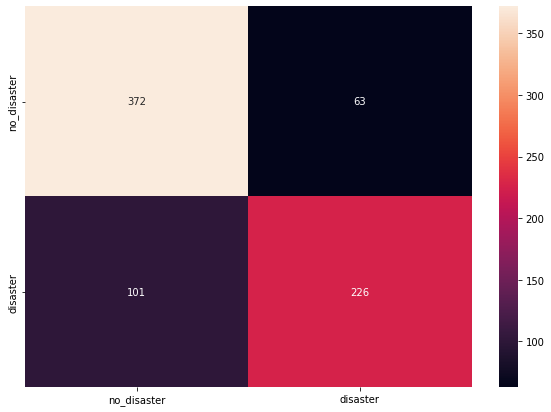

In [89]:
conf_mat = confusion_matrix(y_test, result)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ['no_disaster', 'disaster']],
                  columns = [i for i in ['no_disaster', 'disaster']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g');

- The model on TF-IDF incorrectly classify 101 tweets labeled as disaster as non-disaster.

### Visualizing the top 40 features from TF-IDF

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


http, fire, kill, hiroshima, get, flood, bomb, train, storm, california, disaster, like, https, new, suicide, build, accident, police, attack, crash, report, go, burn, wildfire, evacuate, murder, earthquake, mh, refugees, near, take, people, car, shoot, live, news, emergency, look, riot, full, 
 
 


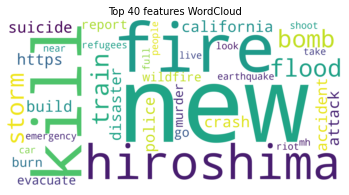

In [90]:
all_features = tfidf_vect.get_feature_names()              #Instantiate the feature from the vectorizer
top_features=''                                            # Addition of top 40 feature into top_feature after training the model
feat= forest.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features+=all_features[i]
    top_features+=', '
    
print(top_features)  

print(" ") 
print(" ") 

from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",colormap='viridis',width=2000, 
                          height=1000).generate(top_features)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(14, 11), frameon='equal')
plt.title('Top 40 features WordCloud', fontsize=10)
plt.axis("off")
plt.show()

### Using GloVE Embeddings
Pretrained GloVe model downloaded from: https://nlp.stanford.edu/projects/glove/

#### Import required libraries



In [43]:
import tensorflow 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [44]:
tokenizer = Tokenizer()        # initializing a tokenizer from Tensorflow

tokenizer.fit_on_texts(train_data['text'])      # tokenizing the text column


In [45]:
# get the word index
word_index = tokenizer.word_index

print("Number of unique tokens: {}".format(len(word_index)))

Number of unique tokens: 19484


### Obtaining Embedding Vectors from GloVe
- Here, we are using GloVe embeddings with 100 dimensions. We use 100 dimensions because too many dimensions would make the model more complex, and could lead to overfitting.

In [50]:
# function to load the GloVe vectors from path
def load_data(path):
  f = open(path, encoding = "utf8")
  return f

embedding_index = {}
f = load_data("/content/drive/MyDrive/glove.6B.100d.txt")
for line in f:
    values = line.split()
    word = values[0]        # get the words in GloVe
    coefs = np.asarray(values[1:], dtype='float32')   # get the coresponding vectors
    embedding_index[word] = coefs
f.close()

print("Number of word vectors: {}".format(len(embedding_index)))

Number of word vectors: 400000


In [62]:
max_words = 6851   # number of rows in the train data

embedding_dim = 100 

embedding_matrix = np.zeros((max_words, embedding_dim))   # Initializing zero vectors
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [63]:
embedding_matrix.shape

(6851, 100)

#### Data Splitting

In [65]:
# split the data into train and test data
train_feat, test_feat, train_label, test_label = train_test_split(embedding_matrix, y_train, 
                                                              test_size = 0.1, random_state=0, stratify = y_train)

#### Building SGD Classifier

In [66]:
from sklearn.linear_model import SGDClassifier

In [67]:
sgd = SGDClassifier(random_state=0)      # initializing the SGD Classifier

sgd.fit(train_feat, train_label)

SGDClassifier(random_state=0)

In [92]:
print(np.mean(cross_val_score(sgd, train_feat, train_label, cv=3)))   # average of the cross-validation accuracies

0.5484184914841849


- Based on the results above, our SGD Classifier would correctly classify a tweet in a new dataset as either real disaster or not 55% of the time.

In [68]:
sgd_pred = sgd.predict(test_feat)          # making prediction with the trained SGD Classifier

### Plot of Evaluation 

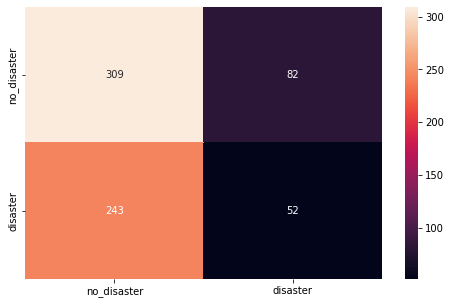

In [69]:
conf_mat = confusion_matrix(test_label, sgd_pred)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ['no_disaster', 'disaster']],
                  columns = [i for i in ['no_disaster', 'disaster']])
plt.figure(figsize = (8,5))
sns.heatmap(df_cm, annot=True, fmt='g');

- Based on the results above, it appears that the SGD Classifier performs the least.
- This is expected as it is a linear model while Random Forest model is able to capture more complex relationships in the data.

##**Summary:**

- We used dataset which has tweets in text format and their categories (real disaster and not real disaster).
- The goal was to build a model for **text-classification**.
- We created a custom function to plot labeled barplots.
- We plotted the percentage of public tweets for each target class. Based on the plot, we have slightly imbalanced dataset.
- We plotted the word cloud of real disaster and no disaster.

- We **Pre-processed** the data using various techniques and libraries.
- The pre-precessed data is **converted(vectorized)** to numbers, so that we can feed the data in the model.
- After **building the classification** model, we performed cross-validation to examine generalization performance.
- We **trained a random forest model with default parameters** 
- After that, we integrated a pre-trained model (GloVe) with an SGD Classifier. Though, the model performed less. 
- One more way to increase accuracy is to use different variations of Pre-processing techniques.

## Recommendation

- Based on the performances of the models, I would recommend that the random forest model be deployed using TF-IDF vectorizers since it gives the best performance.
- Also, it would be best to select the top 100 features predicted by the random forest to rebuild the model to increase its generalization performance.